# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 
1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [6]:
import numpy as np
import logging as log
import sys
log.basicConfig(level=log.INFO, format='>%(message)s', stream=sys.stdout)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

#пример из листочка 1
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
# (array([ 4.,  0.]), 20.0, 1)

In [7]:



def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    return (x==np.array([4,0])).all()

In [114]:
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <=, с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    
    # Если есть отрицательные значения в b, запускаем инициализацию
    if np.count_nonzero(b < 0) > 0:
        pass
    
    # Инициализируем матрицы и прочее
    # Делаем b столбцом
    b = b.reshape((-1, 1))
    
    # Сделаем симплекс-таблицу.
    top = np.hstack((A, b))
    bottom = np.hstack((-c, 0))
    ST = np.vstack([top, bottom]).astype(np.float64)
    
    log.info('%s'%ST)
    n = A.shape[0]
    m = A.shape[1]
    log.info('n=%s, m=%s'%(n, m))
    
    basis = list(range(0, n))
    nonbasis = list(range(n, n+m))
    log.debug("basis %s, nonbasis %s"%(basis, nonbasis))

    iteration_number = 0
    
    #тут рисуем анимацию
#     if draw:
#         fig, ax= plt.subplots(num_iter+1)
#         fig.set_figheight(5*(num_iter+1))
#         fig.set_figwidth(5)
#         xs=[[0,0],[4,0]]

#         for i,a in enumerate(ax):
#             a.plot([0,5],[5,0],  color='b')
#             a.plot([4,0],[0,16], color='b')
#             a.plot([0,0],[0,5], color='b')
#             a.plot([0,4],[0,0], color='b')
#             a.axis([-1, 17, -1, 17])
#             a.set_xlabel('X1')
#             a.set_ylabel('X2')
#             a.set_title('Iteration %d x=(%.2f, %.2f)' % (i+1,xs[i][0],xs[i][1]))

#         ax[0].scatter([0,4,3.66],[5,0,1.33], color='black')
#         ax[0].scatter([0],[0], color='red')

#         ax[1].scatter([0,0,3.66],[0,5,1.33], color='black')
#         ax[1].scatter([4],[0], color='red')


#         
#         plt.show()
    
    def is_valid_solution(x):
        return (A@x.reshape((-1,1))<=b).all() and (x>=0).all()
    
    if draw == True and m != 2:
        draw = False
    
    # Рисует ограничения, допустимые угловые точки отмечает чёрными точками, текущую - красной.
    def draw_lines(x):
        plt.plot()
        a = plt.gca()
        plt.axes().set_aspect('equal')#, 'datalim')
        #a.axis([-1, 17, -1, 17])
        a.set_xlabel('X1')
        a.set_ylabel('X2')
        
        xmax, ymax = 0,0
        # Пересечения
        for i in range(0, A_plot.shape[0]):
            for j in range(0, i):
                if i != j:
                    a_, b_ = A_plot[i]
                    c_ = b_plot[i][0]
                    d_, e_ = A_plot[j]
                    f_ = b_plot[j][0]
                    #print(a_, b_, c_, d_, e_, f_)
                    x_ = (b_*f_-c_*e_)/(b_*d_-a_*e_)
                    y_ = (c_*d_-a_*f_)/(b_*d_-a_*e_)#(c_-a_*x_)/b_
                    if x_ > xmax and x_ != np.inf:
                        xmax = x_
                    if y_ > ymax and y_ != np.inf:
                        ymax = y_
                    #print(x_, y_)
                    if is_valid_solution(np.array([x_, y_])):
                        plt.scatter([x_], [y_], color='black')
        plt.scatter([x[0]], [x[1]], color='red')
        
        #print('xmax ymax', xmax, ymax)
        # Ограничения в виде осей (неотрицательность переменных)
        plt.plot([0, xmax], [0, 0], color='blue')
        plt.plot([0, 0], [ymax, 0], color='blue')
        epsilon = 2
        plt.xlim((-epsilon, xmax+epsilon))
        plt.ylim((-epsilon, ymax+epsilon))
        
        # Ограничения
        for i in range(0, A_plot.shape[0]):
            a_, b_ = A_plot[i]
            c_ = b_plot[i][0]
            #print(a_, b_, c_)
            #print(c_/b_, c_/a_)
            #plt.plot([0, c_/a_], [c_/b_, 0], color='blue')
            
            if c_/b_<0:
                x1, y1 = c_/a_, 0
            else:
                x1, y1 = 0, c_/b_
            if (c_-a_*xmax)/b_ > ymax:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            else:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue')
            
            if c_/a_<0:
                x1, y1 = 0, c_/b_
            else:
                x1, y1 = c_/a_, 0
            if (c_-a_*xmax)/b_ < ymax:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            else:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue')
        
            # Дорисовываем оси до нашей точки.
            #plt.plot([0, c_/a_], [0, 0], color='blue')
            #plt.plot([0, 0], [c_/b_, 0], color='blue')
        
        # plt.set_title('Iteration %d x=(%.2f, %.2f)' % (i+1,xs[i][0],xs[i][1]))

        plt.tight_layout()
        plt.show()
        
    if draw == True:
        A_plot = np.vstack([A, np.array([[1,0], [0,1]])])
        b_plot = np.vstack([b, [[0],[0]]])
        draw_lines([[0],[0]])

    def get_solution(basis, ST):
        x = np.zeros(m)
        w = np.zeros(n)
        for i in range(0, n):
            if 0<=basis[i]<n:
                w[basis[i]] = ST[:,-1][i]
            if basis[i]>=n:
                x[basis[i]-n] = ST[:,-1][i]
        log.info('%s %s', x, w)
        return x, w
    
    def get_leaving_variable(ST):
        if method=='largest_coef':
            return np.argmin(ST[-1][:-1])
        elif method=='blend':
            """minind = [0, 0]
            minval = [n+m,n+m]
            for i in range(len(nonbasis)):
                if nonbasis[i] < n:
                    if nonbasis[i]<minval[0]:
                        minind[0] = i
                        minval[0] = nonbasis[i]
                else:
                    if nonbasis[i]<minval[1]:
                        minind[1] = i
                        minval[1] = nonbasis[i]
            if minval[1] == n+m:
                return minind[0]
            else:
                return minind[1]"""
            return np.argmin(np.ma.array(nonbasis, mask=(ST[-1][:-1]>=0)))
            
        
    solutions = [np.zeros(m)]
    while np.min(ST[-1]) < 0:
        iteration_number += 1
        log.info('          ITERATION #%s'%iteration_number)
        
        #Разрешающий столбец
        log.debug('%s'%ST[-1])
        j = get_leaving_variable(ST)
        log.info('j=%s'%j)

        ratios = ST[:, -1]/ST[:, j]
        log.debug('%s'%ratios)
        i = np.argmin(np.ma.array(ratios[:-1], mask=(ratios[:-1]<0)))
        log.info('i=%s'%i)

        #Строим новую таблицу
        ST_ = ST.copy()
        basis[i], nonbasis[j] = nonbasis[j], basis[i]
        log.info("basis %s, nonbasis %s"%(basis, nonbasis))
        ST_[i][j] = 1/ST[i][j]
        log.debug("%s"%ST_)
        ST_[i][np.arange(m+1) != j] = ST[i][np.arange(m+1) != j]/ST[i][j]
        log.debug("%s"%ST_)
        ST_[:, j][np.arange(n+1) != i] = -ST[:, j][np.arange(n+1) != i]/ST[i][j]
        log.debug("%s"%ST_)

        for i_ in range(0, n+1):
            for j_ in range(0, m+1):
                #print(i_, j_, ST[i_][j],ST[i][j_],ST[i][j])
                if i_ != i and j_ != j:
                    ST_[i_][j_] = ST[i_][j_] - ST[i_][j]*ST[i][j_]/ST[i][j]#(ST[i][j]*ST[i_][j_]-ST[i_][j]*ST[i][j_])/ST[i][j]

        log.info("%s"%ST_)
        ST = ST_
        
        x, w = get_solution(basis, ST)
        solutions.append(x)
        
        if draw == True:
            draw_lines(x)
    
    log.info('FINISHED in %d iterations'%iteration_number)
    
    log.info('path %s'%solutions)
    x, w = get_solution(basis, ST)
    
    return x, ST[-1][-1], iteration_number


In [115]:
#solve_lin_prog(A, b, c, draw=True)

>[[ 1.   2.   5. ]
 [ 2.   0.5  8. ]
 [-5.  -1.   0. ]]
>n=2, m=2


/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in double_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: divide by zero encountered in double_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarni

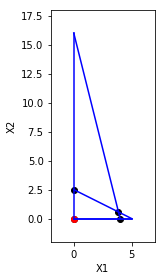

>          ITERATION #1
>j=0
>i=1
>basis [0, 2], nonbasis [1, 3]
>[[ -0.5    1.75   1.  ]
 [  0.5    0.25   4.  ]
 [  2.5    0.25  20.  ]]
>[ 4.  0.] [ 1.  0.]


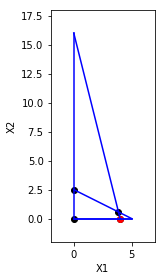

>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([ 4.,  0.])]
>[ 4.  0.] [ 1.  0.]
>[[ 1. -1.  1.]
 [ 2. -1.  3.]
 [ 0.  1.  5.]
 [-4. -3.  0.]]
>n=3, m=2


/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in long_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in less_equal
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: divide by zero encountered in long_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in long_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invali

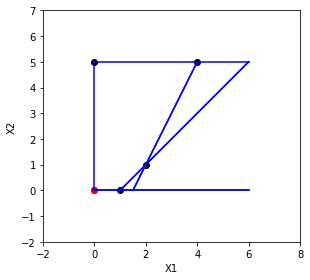

>          ITERATION #1
>j=0
>i=0
>basis [3, 1, 2], nonbasis [0, 4]
>[[ 1. -1.  1.]
 [-2.  1.  1.]
 [-0.  1.  5.]
 [ 4. -7.  4.]]
>[ 1.  0.] [ 0.  1.  5.]


/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:202: RuntimeWarning: divide by zero encountered in true_divide


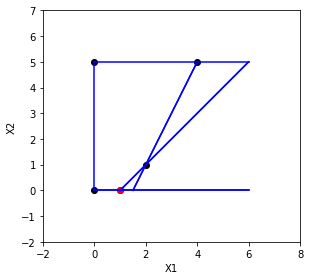

>          ITERATION #2
>j=1
>i=1
>basis [3, 4, 2], nonbasis [0, 1]
>[[ -1.   1.   2.]
 [ -2.   1.   1.]
 [  2.  -1.   4.]
 [-10.   7.  11.]]
>[ 2.  1.] [ 0.  0.  4.]


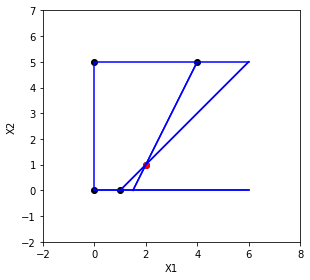

>          ITERATION #3
>j=0
>i=2
>basis [3, 4, 0], nonbasis [2, 1]
>[[  0.5   0.5   4. ]
 [  1.    0.    5. ]
 [  0.5  -0.5   2. ]
 [  5.    2.   31. ]]
>[ 4.  5.] [ 2.  0.  0.]


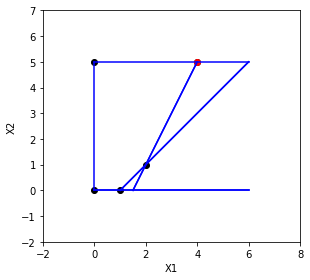

>FINISHED in 3 iterations
>path [array([ 0.,  0.]), array([ 1.,  0.]), array([ 2.,  1.]), array([ 4.,  5.])]
>[ 4.  5.] [ 2.  0.  0.]
>[[  2.   3.   1.   5.]
 [  4.   1.   2.  11.]
 [  3.   4.   2.   8.]
 [ -5.  -4.  -3.   0.]]
>n=3, m=3
>          ITERATION #1
>j=0
>i=0
>basis [3, 1, 2], nonbasis [0, 4, 5]
>[[  0.5   1.5   0.5   2.5]
 [ -2.   -5.    0.    1. ]
 [ -1.5  -0.5   0.5   0.5]
 [  2.5   3.5  -0.5  12.5]]
>[ 2.5  0.   0. ] [ 0.   1.   0.5]
>          ITERATION #2
>j=2
>i=2
>basis [3, 1, 5], nonbasis [0, 4, 2]
>[[  2.   2.  -1.   2.]
 [ -2.  -5.  -0.   1.]
 [ -3.  -1.   2.   1.]
 [  1.   3.   1.  13.]]
>[ 2.  0.  1.] [ 0.  1.  0.]
>FINISHED in 2 iterations
>path [array([ 0.,  0.,  0.]), array([ 2.5,  0. ,  0. ]), array([ 2.,  0.,  1.])]
>[ 2.  0.  1.] [ 0.  1.  0.]
>[[  1.    1.    1.    1.   40. ]
 [  2.    1.   -1.   -1.   10. ]
 [  0.   -1.    0.    1.   10. ]
 [ -0.5  -3.   -1.   -4.    0. ]]
>n=3, m=4
>          ITERATION #1
>j=0
>i=1
>basis [0, 3, 2], nonbasis [1, 4, 5, 

In [117]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True)
corr_ans = (np.array([ 4.,  0.]), 20.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])

A=np.array([[1,-1],[2,-1], [0, 1]])
b=np.array([1,3,5])
c=np.array([4,3])
ans = solve_lin_prog(A, b, c, draw=True)
corr_ans = (np.array([ 4.,  5.]), 31.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])

A=np.array([[2,3,1],[4,1,2],[3,4,2]])
b=np.array([5, 11, 8])
c=np.array([5, 4, 3])
ans = solve_lin_prog(A, b, c, draw=True)
corr_ans = (np.array([ 2.,  0.,  1.]), 13.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])

A=np.array([[1,1,1,1],[2,1,-1,-1],[0,-1,0,1]])
b=np.array([40, 10, 10])
c=np.array([0.5, 3,1,4])
ans = solve_lin_prog(A, b, c, draw=True)
corr_ans = (np.array([  0.,  15.,   0.,  25.]), 145.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])

In [ ]:
x, best, n_iter = solve_lin_prog(A,b,c, draw=True)

In [7]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

Точка:  [4 0]
Ответ:  20
Число итераций:  1


In [8]:
is_optimal(A,b,c,x)

True

# ==========================================================
# Задача на МНК (0.4 балла)

In [6]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]
    
"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m=200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,σ,m)
    return y_real, y_corr

#todo -выбрать параметр
σ=0.5

#генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,σ)


def get_params (y_corr, t, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq()
    
    
    return [0,0,0]

## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [7]:
sample = np.random.normal(size=(200, 80))


## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)